## AIMI High School Internship 2023
### Notebook 1: Extracting Labels from Radiology Reports

**The Problem**: Given a chest X-ray, our goal in this project is to predict the distance from an endotracheal tube to the carina. This is an important clinical task - endotracheal tubes that are positioned too far (>5cm) above the carina will not work effectively.

In order to train a model that can predict tube distances given chest X-rays, we require a ***training set*** with chest X-rays and labeled tube distances. However, when working with real-world medical data, important labels (e.g. endotracheal tube distances) are often not annotated ahead of time. The only data that a researcher has access to are the raw images and free-form clinical text written by the radiologist.

**Your First Task**: Given a set of chest X-rays and paired radiology reports, your goal is to use natural language processing tools to extract endotracheal tube distances from the reports.

**Looking Ahead**: When you complete this task, you should have a training dataset with chest X-rays labeled with endotracheal tube distances. You will later use this dataset to train a computer vision model that predicts the tube distance given an image.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Data

Upload `data.zip`. It should take about 10 minutes for these files to be uploaded. Then, run the following cells to unzip the dataset (which should take < 10 seconds)

In [ ]:
!unzip -qq /content/drive/MyDrive/MIMICDATA-Research.zip

In [ ]:
!unzip -qq /content/mimic-train.zip
!unzip -qq /content/mimic-test.zip

### Understanding the Data

Let's first go through some terminology. Medical data is often stored in a hierarchy consisting of three levels: patient, study, and images.
- Patient: A patient is a single unique individual.
- Study: Each patient may have multiple sets of images taken, perhaps on different days. Each set of images is referred to as a *study*.
- Images: Each study consists of one or more *images*.

Chest X-ray images and radiology reports are stored in `data/` and are organized as follows:
- `data/mimic-train`:
  - Images: The MIMIC training set consists of 5313 subfolders, each representing a patient. Every patient has one or more studies, which are stored as subfolders. Images are stored in study folders as `.jpg` files with 512x512 pixels.
  - Text: Reports are stored in patient folders with  `.txt` extensions. The filename corresponds to the study id and the content of the report applies to all images in the corresponding study.
- `data/mimic-test`: The MIMIC test set is organized in a similar fashion as the MIMIC training set. Note that this is a held-out test set with 500 images that we will use for scoring models, so reports are not provided!
- `data/mimic_train_student.csv`: This spreadsheet provides mappings between image paths, report paths, patient ids, study ids, and image ids for samples in the training set.
- `data/mimic_test_student.csv`: This spreadsheet provides mappings between image paths, patient ids, study ids, and image ids for samples in the test set.

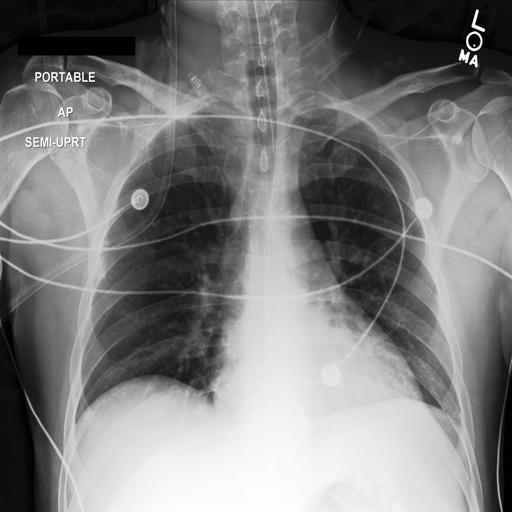

In [ ]:
# Example Image
from PIL import Image
img = Image.open(f"/content/mimic-train/12000/59707/90529.jpg")
img.show()

In [ ]:
# Example Text Report
with open(f"/content/mimic-train/12000/59707.txt", "r") as f:
  txt = f.readlines()
txt

['                                 FINAL REPORT\n',
 ' PORTABLE CHEST ___\n',
 ' \n',
 ' COMPARISON:  ___ radiograph.\n',
 ' \n',
 ' FINDINGS:  Tip of endotracheal tube terminates 6 cm above the carina. \n',
 ' Cardiomediastinal contours are normal in appearance, and lungs are grossly\n',
 ' clear.\n']

In [ ]:
# Load csv file with mappings
import pandas as pd
pd.read_csv('/content/mimic_train_student.csv')

,Unnamed: 0,patient_id,study_id,image_id,image_path,report_path
0,0,13282,56112,91263,mimic-train/13282/56112/91263.jpg,mimic-train/13282/56112.txt
1,1,13282,58693,86967,mimic-train/13282/58693/86967.jpg,mimic-train/13282/58693.txt
2,2,13360,54397,84764,mimic-train/13360/54397/84764.jpg,mimic-train/13360/54397.txt
3,3,13360,57560,92873,mimic-train/13360/57560/92873.jpg,mimic-train/13360/57560.txt
4,4,13360,62326,88457,mimic-train/13360/62326/88457.jpg,mimic-train/13360/62326.txt
...,...,...,...,...,...,...
12240,12240,13795,60202,87633,mimic-train/13795/60202/87633.jpg,mimic-train/13795/60202.txt
12241,12241,13795,60202,82617,mimic-train/13795/60202/82617.jpg,mimic-train/13795/60202.txt
12242,12242,13818,59053,93743,mimic-train/13818/59053/93743.jpg,mimic-train/13818/59053.txt
12243,12243,13906,62812,85124,mimic-train/13906/62812/85124.jpg,mimic-train/13906/62812.txt


### Extracting Tube Distance Labels

You're now ready to begin this task! Keep in mind that not every chest X-ray provided in the training set contains endotracheal tube distance information, and there may be several edge cases to consider.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.7 MB/s eta 0:00:00


In [ ]:
def is_cm(string):
  valid = "0123456789., "
  unit = None
  for char in string:
    if valid.find(char) == -1:
      unit = char
      break
  return unit

def validate(string):
  valid = "0123456789CcentiMmrl,. "

  for i, char in enumerate(string):
    if valid.find(char) == -1:
      return False
  return True

def handle_no_space(string):
  valid = "0123456789"
  end_of_int = 0

  for i, char in enumerate(string):
    if valid.find(char) == -1:
      end_of_int = i - 1
  return string[:end_of_int] + ".0"

def handle_space(string):
  space_loc = string.find(" ")
  if space_loc != -1:
      return string.split(" ")[0] + ".0"
  return handle_no_space(string)

def handle_period(string):
  out = ""
  valid = "0123456789."
  for i, char in enumerate(string):
    if valid.find(char) != -1:
      out += char
  if out[len(out) - 1] == ".":
    out = out[:len(out) - 1]
    return out
  return out

def parse_measure(measurement):
  comma_loc = measurement.find(",")
  period_loc = measurement.find(".")
  # no comma or period
  if period_loc == -1 and comma_loc == -1:
    return handle_space(measurement)
  # only a comma
  if comma_loc != -1:
    measurement = measurement.replace(",", ".")
  # at this point, all strings that made it
  # this far have only a period
  return handle_period(measurement)

def parse_report(path):
  with open(f"data/{path}", "r") as f:
    txt = f.readlines()
  return "".join(txt).replace("\n", "")

In [ ]:
# Test 1: 3.5 cm
print("3.5" == parse_measure("3.5 cm"))
# parse_measure("3.5 cm")

# Test 2: 3,5 cm
print("3.5" == parse_measure("3,5 cm"))
# parse_measure("3,5 cm")

# Test 3: 3 . 5 centimeter
print("3.5" == parse_measure("3 . 5 centimeter"))
# parse_measure("3 . 5 centimeter")

# Test 4: 3.5centimeters
print("3.5" == parse_measure("3.5centimeters"))
# parse_measure("3.5centimeters")

# Test 5: 3,5 centimetrs
print("3.5" == parse_measure("3,5 centimetrs"))
# parse_measure("3,5 centimetrs")

# Test 6: 3 cm
print("3.0" == parse_measure("3 cm"))
# parse_measure("3 cm")

# Test 7: 3.0 cm
print("3.0" == parse_measure("3.0 cm"))
# parse_measure("3.0 cm")

# Test 8: 12.5 cm
print("12.5" == parse_measure("12.5. cm"))
# parse_measure("3.5 cm")

# Test 9: 22,5 cm
print("22.5" == parse_measure("22,5 cm"))
# parse_measure("3,5 cm")

# Test 10: 25 . 5 centimeter
print("25.5" == parse_measure("25 . 5 centimeter"))
# parse_measure("3 . 5 centimeter")

# Test 11: 361.5centimeters
print("361.5" == parse_measure("361.5centimeters"))
# parse_measure("3.5centimeters")

# Test 12: 46,5 centimetrs
print("46.5" == parse_measure("46,5 centimetrs"))
# parse_measure("3,5 centimetrs")

# Test 13: 75 cm
print("75.0" == parse_measure("75 cm"))
# parse_measure("3 cm")

# Test 14: 232.0 cm
print("232.0" == parse_measure("232.0 cm"))
# parse_measure("3.0 cm")

# Test 15: 232.0 cm
print("232.0" == parse_measure("2 3 2 .    0 cm"))
# parse_measure("3.0 cm")

# Test 16: 232 mm
print("m" == is_cm("232 mm"))

# Test 17: 232.0 millimietr
print("m" == is_cm("232.0 millimietr"))

# Test 18: 257 , 0 cm
print("c" == is_cm("257 , 0 cm"))

# Test 19: 25 , 0 cm
print("c" == is_cm("257 , 0 cm"))

# Test 20: 25
print(None == is_cm("25"))

# Test 21: 2 and 3 cm
print(False == validate("2 and 3 cm"))

# Test 22: 2 or 3 cm
print(False == validate("2 or 3 cm"))

# Test 23: 2-3 cm
print(False == validate("2-3 cm"))

# Test 24: less than 2 cm:
print(False == validate("less than 2 cm"))

# Test 25: 2 away
print(False == validate("2 away"))

# Test 26:
print(True == validate("2 3 2 .    0 cm"))

# Test 27:
print(True == validate("25 . 5 centimeter"))

# Test 28:
print(True == validate("22,5 cm"))



True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModelForQuestionAnswering

 # pass device=0 if using gpu



def roberta_squad2(report):
  question = "What is the exact distance between the ETT device and the carina?"

  model_name = "deepset/roberta-base-squad2"
  model = AutoModelForQuestionAnswering.from_pretrained(model_name)
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  pipe = pipeline('question-answering', model=model, tokenizer=tokenizer)

  qa_input = {
      'question': question,
      'context': report
  }

  return pipe(qa_input)['answer']

def get_distance(report):
  measure_roberta = roberta_squad2(report)
  roberta_valid = validate(measure_roberta)
  if not roberta_valid:
    return "-1"
  if roberta_valid and is_cm(measure_roberta) is not None:
    return measure_roberta
  return "-2"

def get_biomed_token_class(report):
  response = biomed_token_class(report)
  measure = "-1"
  max_score = 0
  for json in response:
    if json["entity_group"] == "Distance" and json["score"] > max_score:
      measure = json["word"]
      max_score = json["score"]
  return measure

NOT_VALID = -1.0
NO_UNITS = -2.0

def process_volume(path):
  report = parse_report(path)
  distance = get_distance(report)
  if distance == "-1":
    return NOT_VALID
  if distance == "-2":
    return NO_UNITS
  unit = is_cm(distance)
  measurement = parse_measure(distance)
  if unit == "m" or unit == "M":
    return float(measurement) / 10.0
  return float(measurement)

In [ ]:

def good_positioning(measure):
  if measure < 0:
    return -1
  if measure <= 5:
    return 1
  return 0


# Load csv file with mappings
import pandas as pd
import numpy as np

def get_labels(data):
  PATH = f"/content/mimic_train_student.csv"
  subjects = pd.read_csv(PATH)
  subjects = subjects.drop(columns=["Unnamed: 0", "study_id", "image_id"])
  report_paths = subjects["report_path"].to_numpy()
  measures = []
  positioning = [] # 1 is good, 0 is bad

  for i, path in enumerate(report_paths):
    if i % 100 == 0:
      print(f"Progress checkpoint, processed {i} volumes. {len(report_paths) - (i)} remain.")
    if i % 1000 == 0:
      print(f"Saving {i} data points to data/batch-{i}.csv")
      checkpoint = pd.DataFrame()
      checkpoint["measures"] = measures
      checkpoint["positioning"] = positioning
      checkpoint.to_csv(f"data/batch-{i}.csv")

    measure = process_volume(path)
    measures.append(measure)
    positioning.append(good_positioning(measure))

  subjects["measures"] = measures
  subjects["positioning"] = positioning
  subjects.to_csv(f"data/mimic_{data}_labels.csv")

get_labels(data="train")
print("Task completed.")

Progress checkpoint, processed 0 volumes. 12245 remain.
Saving 0 data points to content/batch-0.csv


OSError: ignored

In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassificationb


tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")
model = AutoModelForTokenClassification.from_pretrained("d4data/biomedical-ner-all")


dataset_path = "/content/mimic_train_student.csv"
dataset = pd.read_csv(dataset_path)


def extract_distance(report_path):
    tokens = tokenizer.tokenize(report_path)
    distance = len(tokens)

    return distance

distances = []

Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")
model = AutoModelForTokenClassification.from_pretrained("d4data/biomedical-ner-all")

dataset_path = "/content/mimic_train_student.csv"
dataset = pd.read_csv(dataset_path)

dataset["extracted_distance"] = ""
distances = []
for index, row in dataset.iterrows():
    report_path = row["report_path"]

    if report_path.endswith(".txt"):
        with open(report_path, "r") as f:
            report_text = f.read()

        tokens = tokenizer.tokenize(report_text)
        input_ids = input_ids[:, :512]
        padding_length = 512 - input_ids.shape[1]
        padding_ids = torch.zeros((input_ids.shape[0], padding_length), dtype=torch.long)
        input_ids = torch.cat((input_ids, padding_ids), dim=1)

        outputs = model(input_ids)
        predictions = torch.argmax(outputs.logits, dim=2)
        labels = tokenizer.convert_ids_to_tokens(predictions.squeeze().tolist())

        distance_label = ""
        for token, label in zip(tokens, labels):
            if label != "O":
                distance_label += token.replace("##", "")
            else:
                break

        dataset.at[index, "extracted_distance"] = distance_label
new_column = {"report_path": "All Reports", "extracted_distance": " | ".join(distances)}
dataset = dataset.append(new_column, ignore_index=True)
# Save the modified dataset
output_dataset_path = "/content/mimic_train_student_modified.csv"
dataset.to_csv(output_dataset_path, index=False)
print(dataset)

Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512). Running this sequence through the model will result in indexing errors
